In [24]:
import sys
import h5py
import warnings
import os
from os import path
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy import ndarray
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
project_dir = "/content/drive/MyDrive/"
os.chdir(project_dir)

**1. Import the dataset.**

In [27]:

import numpy as np
data = np.load('Dataset- Images.npy', allow_pickle=True)

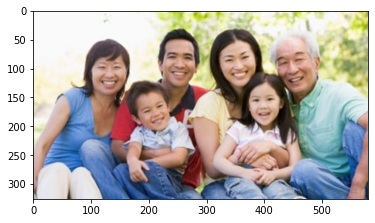

In [28]:
plt.imshow(data[4][0])

In [29]:
data[4][1]

[{'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.5586206896551724, 'y': 0.19938650306748465},
   {'x': 0.6603448275862069, 'y': 0.3773006134969325}]},
 {'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.38620689655172413, 'y': 0.18711656441717792},
   {'x': 0.4896551724137931, 'y': 0.4049079754601227}]},
 {'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.1724137931034483, 'y': 0.23006134969325154},
   {'x': 0.2775862068965517, 'y': 0.44171779141104295}]},
 {'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7155172413793104, 'y': 0.19938650306748465},
   {'x': 0.8448275862068966, 'y': 0.41411042944785276}]},
 {'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.2982758620689655, 'y': 0.44171779141104295},
   {'x': 0.4189655172413793, 'y': 0.65337423

**2. Create features (images) and labels (mask) using that data.**

In [30]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [31]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [32]:
X_train.shape

(409, 224, 224, 3)

In [33]:
masks.shape

(409, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.59215689  0.68627453 -0.08235294]
  [ 0.49019611  0.57647061 -0.17647058]
  [ 0.51372552  0.60784316 -0.13725489]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.66274512  0.74117649 -0.01960784]
  [ 0.54509807  0.64705884 -0.13725489]
  [ 0.47450984  0.56862748 -0.23921567]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.7647059   0.82745099  0.05098045]
  [ 0.58431375  0.67058825 -0.17647058]
  [ 0.34901965  0.45098042 -0.48235291]]

 ...

 [[ 0.34901965  0.34901965  0.41960788]
  [ 0.52941179  0.52941179  0.60784316]
  [ 0.28627455  0.28627455  0.34901965]
  ...
  [ 0.14509809 -0.10588235 -0.09803921]
  [-0.69411767 -0.62352943 -0.4588235 ]
  [-0.89019608 -0.74117649 -0.46666664]]

 [

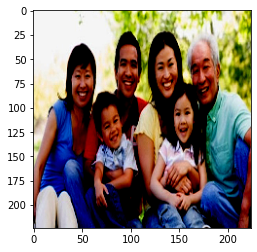

In [34]:
n = 4
print(X_train[n])
plt.imshow(X_train[n])

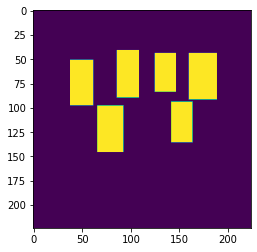

In [35]:
plt.imshow(masks[4])

**3. Mask detection model:**



> **Design a face mask detection model.**


Hint: Use U-net along with pre-trained transfer learning models 






In [36]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def create_model(trainable=True):
    model = model = MobileNet(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, alpha=ALPHA,weights="imagenet") # Load pre-trained mobilenet
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    
    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_WIDTH, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)

In [37]:
model=create_model()
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________



> **Design your own Dice Coefficient and Loss function.**



In [38]:
def dice_coefficient(y_true, y_pred):
    #### Add your code here ####
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())



> **Train, tune and test the model.**



In [39]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [40]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [42]:
X_train, X_val, y_train, y_val = train_test_split(
     X_train, masks, test_size=0.33, random_state=42)

In [43]:
EPOCHS = 10

In [44]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=EPOCHS, batch_size=1, verbose=1,callbacks=[checkpoint,stop,reduce_lr])

Epoch 1/10
274/274 [==============================] - 409s 1s/step - loss: 1.5150 - dice_coefficient: 0.3940 - val_loss: 1.7636 - val_dice_coefficient: 0.3622

Epoch 00001: loss improved from inf to 1.40077, saving model to model-1.40.h5
Epoch 2/10
274/274 [==============================] - 399s 1s/step - loss: 0.7999 - dice_coefficient: 0.6138 - val_loss: 1.4080 - val_dice_coefficient: 0.4200

Epoch 00002: loss improved from 1.40077 to 0.84095, saving model to model-0.84.h5
Epoch 3/10
274/274 [==============================] - 396s 1s/step - loss: 0.7255 - dice_coefficient: 0.6560 - val_loss: 1.1363 - val_dice_coefficient: 0.4850

Epoch 00003: loss improved from 0.84095 to 0.68321, saving model to model-0.68.h5
Epoch 4/10
274/274 [==============================] - 406s 1s/step - loss: 0.5679 - dice_coefficient: 0.7041 - val_loss: 1.1010 - val_dice_coefficient: 0.5076

Epoch 00004: loss improved from 0.68321 to 0.61964, saving model to model-0.62.h5
Epoch 5/10
274/274 [================



> **Evaluate the model using testing data.**



In [60]:
n = 21
sample_image = X_val[n]

print(sample_image.shape)
sample_image_reshaped = np.reshape(sample_image,(1,sample_image.shape[0],sample_image.shape[1],sample_image.shape[2]))
print(sample_image_reshaped.shape)
predicted_mask = model.predict(sample_image_reshaped)

(224, 224, 3)
(1, 224, 224, 3)


In [61]:
print(predicted_mask.shape)
print(y_val[n].shape)
predicted_mask_reshaped = np.reshape(predicted_mask,y_val[n].shape)
print(predicted_mask_reshaped.shape)

(1, 224, 224)
(224, 224)
(224, 224)


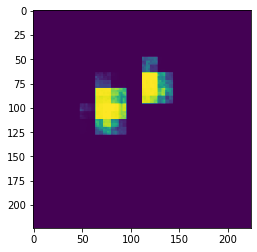

In [62]:
plt.imshow(predicted_mask_reshaped)

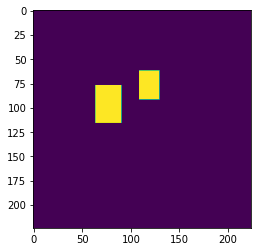

In [63]:

plt.imshow(y_val[n])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


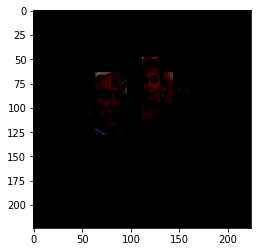

In [64]:
plt.imshow(sample_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


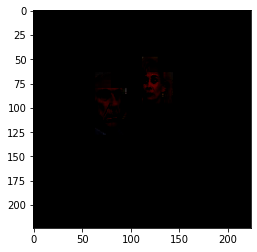

In [65]:
pred_mask = predicted_mask_reshaped

image2 = sample_image
image2[:,:,0] = pred_mask*sample_image[:,:,0]
image2[:,:,1] = pred_mask*sample_image[:,:,1]
image2[:,:,2] = pred_mask*sample_image[:,:,2]


out_image = image2

plt.imshow(out_image)

**4. Use the “Prediction image” as an input to your designed model and display the output of the image.**

In [66]:
from PIL import Image
from numpy import array

In [67]:
image = Image.open('/content/drive/MyDrive/Prediction_Image.jpeg')

In [68]:
print(image.format)
print(image.size)
print(image.mode)

JPEG
(500, 500)
RGB


In [69]:
numpydata = array(image)

In [70]:
img = cv2.resize(numpydata, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)

In [71]:
prediction_image_reshaped = np.reshape(img,(1,224,224,3))
print(prediction_image_reshaped.shape)
predicted_mask = model.predict(prediction_image_reshaped)

(1, 224, 224, 3)


In [72]:
print(predicted_mask.shape)
print(img.shape)
predicted_mask_reshaped = np.reshape(predicted_mask,y_val[n].shape)
print(predicted_mask_reshaped.shape)

(1, 224, 224)
(224, 224, 3)
(224, 224)


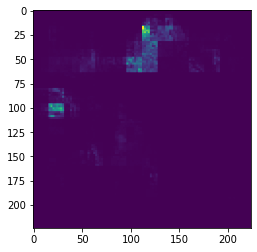

In [73]:
plt.imshow(predicted_mask_reshaped)

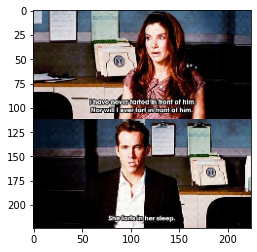

In [74]:
plt.imshow(img)


**PART TWO**

In [13]:
from tqdm import tqdm

In [234]:
range(len(data))

range(0, 409)

In [235]:
images = []
for i in tqdm(range(len(data))):
    img = data[i][0]
    images.append([img, data[i][1]])

100%|██████████| 409/409 [00:00<00:00, 259526.53it/s]


In [236]:
count = 1
for image in images:
    img = image[0]
    cv2.imwrite('/content/drive/MyDrive/ACV_project1/Images/Image{}.jpg'.format(count),cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    count += 1
    

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

In [240]:
image_path='/content/drive/MyDrive/ACV_project1/Images/Image1.jpg'

In [241]:
image_path.split('/')[-1]

'Image1.jpg'

In [12]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def build_classifier_data(image_path):
  return_data = []
  image_name = image_path.split('/')[-1]
  #print(image_name)
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  #print(face_cascade)
  img = cv2.imread(image_path)
  #print(img)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #print(gray)
  faces = face_cascade.detectMultiScale(gray, 1.3, 6)
  for (x,y,w,h) in faces:
    tmp = {}
    tmp['x'] = x
    tmp['y'] = y
    tmp['w'] = w
    tmp['h'] = h
    tmp['Total_faces'] = len(faces)
    tmp['Image_name'] = image_name
    return_data.append(tmp)
  return pd.DataFrame(return_data)
  

In [297]:
cas=cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
cas

'/usr/local/lib/python3.7/dist-packages/cv2/data/haarcascade_frontalface_default.xml'

In [298]:
build_classifier_data('/content/drive/MyDrive/ACV_project1/Images/Image1.jpg')

,x,y,w,h,total_faces,image_name
0,380,94,55,55,2,Image1.jpg
1,59,95,53,53,2,Image1.jpg


In [19]:
build_classifier_data('/content/drive/MyDrive/ACV_project1/Images/Image5.jpg')

,x,y,w,h,total_faces,image_name
0,215,52,75,75,5,Image5.jpg
1,314,52,78,78,5,Image5.jpg
2,92,74,66,66,5,Image5.jpg
3,366,128,68,68,5,Image5.jpg
4,179,145,62,62,5,Image5.jpg


In [23]:
#First have saved all the images on drive then used cv2 CascadeClassifier